<a href="https://colab.research.google.com/github/FarrelAD/Hology-8-2025-Data-Mining-PRIVATE/blob/main/notebooks/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/Cognivio/Hology-8-2025-Data-Mining-PRIVATE
/blob/main/notebooks/training.ipynb" target="_blank">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Object Detection Training

# By claude

## Preparation

In [3]:
!pip install -q kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


Download dataset directly from Kaggle competition using Kaggle CLI (not persistent)

In [ ]:
!kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining

import zipfile
import os

zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")


 57% 118M/209M [00:00<00:00, 1.23GB/s]
100% 209M/209M [00:00<00:00, 795MB/s] 


Download dataset persistently (mounting to Google Drive)

In [5]:
!kaggle competitions download -c penyisihan-hology-8-0-2025-data-mining

import zipfile
import os
from google.colab import drive


drive.mount('/content/drive')

zip_path = "/content/penyisihan-hology-8-0-2025-data-mining.zip"
extract_path = "/content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)

penyisihan-hology-8-0-2025-data-mining.zip: Skipping, found more recently modified local copy (use --force to force download)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to: /content/drive/MyDrive/PROJECTS/Cognivio/Percobaan Hology 8 2025/dataset


---

Install primary packages for model training

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Loading

In [ ]:
# Data loading and preprocessing functions
class ObjectDetectionDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, img_size=416):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_size = img_size
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = image.shape[:2]

        # Resize image
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0

        # Load label (assuming YOLO format: class x_center y_center width height)
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt')
        label_path = os.path.join(self.label_dir, label_name)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        boxes.append([class_id, x_center, y_center, width, height])

        if len(boxes) == 0:
            boxes = [[0, 0.5, 0.5, 0.1, 0.1]]  # dummy box if no annotations

        boxes = np.array(boxes, dtype=np.float32)

        if self.transform:
            image = self.transform(image)
        else:
            image = torch.FloatTensor(image).permute(2, 0, 1)

        return image, torch.FloatTensor(boxes)

# Load dataset
train_dataset = ObjectDetectionDataset(
    image_dir='/content/dataset/train/images',
    label_dir='/content/dataset/train/labels',
    img_size=416
)

test_dataset = ObjectDetectionDataset(
    image_dir='/content/dataset/test/images',
    label_dir='/content/dataset/test/labels',
    img_size=416
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1900
Test samples: 500


## Model Initialization

In [ ]:
# Simple CNN-based object detector
class SimpleObjectDetector(nn.Module):
    def __init__(self, num_classes=1):
        super(SimpleObjectDetector, self).__init__()
        self.num_classes = num_classes

        # Feature extraction backbone
        self.backbone = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Detection head
        # Output: [confidence, x_center, y_center, width, height] per grid cell
        self.detection_head = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 5, 1)  # 5 = 1 confidence + 4 bbox coordinates
        )

    def forward(self, x):
        features = self.backbone(x)
        detections = self.detection_head(features)
        return detections

# Initialize model
model = SimpleObjectDetector(num_classes=1).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

Model parameters: 1469861


## Training

In [ ]:
# Training functions
def calculate_loss(predictions, targets, lambda_coord=5.0, lambda_noobj=0.5):
    """
    Simple loss function for object detection
    predictions: [batch, 5, grid_h, grid_w]
    targets: [batch, max_objects, 5] (class, x, y, w, h)
    """
    batch_size = predictions.size(0)
    grid_h, grid_w = predictions.size(2), predictions.size(3)

    total_loss = 0

    for b in range(batch_size):
        pred = predictions[b]  # [5, grid_h, grid_w]
        target = targets[b]    # [max_objects, 5]

        # Simple approach: assign each target to nearest grid cell
        for obj in target:
            if obj[0] >= 0:  # valid object
                # Convert normalized coordinates to grid coordinates
                grid_x = int(obj[1] * grid_w)
                grid_y = int(obj[2] * grid_h)
                grid_x = min(max(grid_x, 0), grid_w - 1)
                grid_y = min(max(grid_y, 0), grid_h - 1)

                # Get prediction for this grid cell
                pred_conf = torch.sigmoid(pred[0, grid_y, grid_x])
                pred_x = torch.sigmoid(pred[1, grid_y, grid_x])
                pred_y = torch.sigmoid(pred[2, grid_y, grid_x])
                pred_w = pred[3, grid_y, grid_x]
                pred_h = pred[4, grid_y, grid_x]

                # Target values
                target_conf = 1.0
                target_x = obj[1] * grid_w - grid_x
                target_y = obj[2] * grid_h - grid_y
                target_w = torch.log(obj[3] + 1e-8)
                target_h = torch.log(obj[4] + 1e-8)

                # Calculate losses
                conf_loss = (pred_conf - target_conf) ** 2
                coord_loss = (pred_x - target_x) ** 2 + (pred_y - target_y) ** 2
                size_loss = (pred_w - target_w) ** 2 + (pred_h - target_h) ** 2

                total_loss += conf_loss + lambda_coord * (coord_loss + size_loss)

    return total_loss / batch_size

def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)

    # Pad targets to same length
    max_objects = max(len(t) for t in targets)
    padded_targets = []
    for target in targets:
        if len(target) < max_objects:
            padding = torch.full((max_objects - len(target), 5), -1)
            target = torch.cat([target, padding])
        padded_targets.append(target)

    targets = torch.stack(padded_targets)
    return images, targets

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Training loop
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        predictions = model(images)
        loss = calculate_loss(predictions, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss:.4f}')

print("Training completed!")

Epoch 1/10, Batch 0, Loss: 55.6743
Epoch 1/10, Batch 10, Loss: 7.5310
Epoch 1/10, Batch 20, Loss: 5.1315
Epoch 1/10, Batch 30, Loss: 0.9571
Epoch 1/10, Batch 40, Loss: 1.8863
Epoch 1/10, Batch 50, Loss: 0.1880
Epoch 1/10, Batch 60, Loss: 0.2377
Epoch 1/10, Batch 70, Loss: 1.5756
Epoch 1/10, Batch 80, Loss: 0.6521
Epoch 1/10, Batch 90, Loss: 0.5734
Epoch 1/10, Batch 100, Loss: 0.2021
Epoch 1/10, Batch 110, Loss: 1.9528
Epoch 1/10, Batch 120, Loss: 0.0623
Epoch 1/10, Batch 130, Loss: 11.0825
Epoch 1/10, Batch 140, Loss: 2.4178
Epoch 1/10, Batch 150, Loss: 1.7948
Epoch 1/10, Batch 160, Loss: 4.1679
Epoch 1/10, Batch 170, Loss: 0.1239
Epoch 1/10, Batch 180, Loss: 0.2291
Epoch 1/10, Batch 190, Loss: 1.4106
Epoch 1/10, Batch 200, Loss: 0.4568
Epoch 1/10, Batch 210, Loss: 2.4105
Epoch 1/10, Batch 220, Loss: 0.9526
Epoch 1/10, Batch 230, Loss: 0.3918
Epoch 1/10, Batch 240, Loss: 0.1573
Epoch 1/10, Batch 250, Loss: 0.0137
Epoch 1/10, Batch 260, Loss: 1.1104
Epoch 1/10, Batch 270, Loss: 2.0801
E

## Prediction

In [ ]:
# Prediction and visualization functions
def predict_objects(model, image, conf_threshold=0.5, img_size=416):
    """
    Predict objects in an image
    """
    model.eval()

    # Preprocess image
    if isinstance(image, str):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    orig_h, orig_w = image.shape[:2]
    resized_image = cv2.resize(image, (img_size, img_size))
    input_tensor = torch.FloatTensor(resized_image).permute(2, 0, 1).unsqueeze(0) / 255.0
    input_tensor = input_tensor.to(device)

    with torch.no_grad():
        predictions = model(input_tensor)

    # Post-process predictions
    predictions = predictions.squeeze(0)  # Remove batch dimension
    grid_h, grid_w = predictions.size(1), predictions.size(2)

    detections = []
    for i in range(grid_h):
        for j in range(grid_w):
            conf = torch.sigmoid(predictions[0, i, j]).item()

            if conf > conf_threshold:
                # Get bbox coordinates
                x_offset = torch.sigmoid(predictions[1, i, j]).item()
                y_offset = torch.sigmoid(predictions[2, i, j]).item()
                w = torch.exp(predictions[3, i, j]).item()
                h = torch.exp(predictions[4, i, j]).item()

                # Convert to absolute coordinates
                x_center = (j + x_offset) / grid_w
                y_center = (i + y_offset) / grid_h

                # Convert to original image coordinates
                x_center *= orig_w
                y_center *= orig_h
                width = w * orig_w / grid_w
                height = h * orig_h / grid_h

                x1 = int(x_center - width/2)
                y1 = int(y_center - height/2)
                x2 = int(x_center + width/2)
                y2 = int(y_center + height/2)

                detections.append({
                    'confidence': conf,
                    'bbox': [x1, y1, x2, y2],
                    'center': [x_center, y_center],
                    'size': [width, height]
                })

    return detections

def visualize_predictions(image_path, detections, save_path=None):
    """
    Visualize predictions on image
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 8))
    plt.imshow(image)

    for det in detections:
        x1, y1, x2, y2 = det['bbox']
        conf = det['confidence']

        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                           fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)

        # Add confidence text
        plt.text(x1, y1-5, f'Conf: {conf:.3f}',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
                fontsize=10, color='white')

    plt.title(f'Object Detection Results ({len(detections)} objects detected)')
    plt.axis('off')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.show()

## Testing


Testing on image: 455.jpg
Detected 676 objects
  Object 1: Confidence = 0.982, BBox = [-5, -3, 6, 4]
  Object 2: Confidence = 0.998, BBox = [35, -2, 42, 2]
  Object 3: Confidence = 0.997, BBox = [75, -2, 82, 2]
  Object 4: Confidence = 0.997, BBox = [114, -2, 122, 2]
  Object 5: Confidence = 0.997, BBox = [153, -2, 161, 2]
  Object 6: Confidence = 0.997, BBox = [193, -2, 200, 2]
  Object 7: Confidence = 0.997, BBox = [232, -2, 240, 2]
  Object 8: Confidence = 0.997, BBox = [272, -2, 279, 2]
  Object 9: Confidence = 0.997, BBox = [311, -2, 318, 2]
  Object 10: Confidence = 0.997, BBox = [350, -2, 358, 2]
  Object 11: Confidence = 0.997, BBox = [390, -2, 397, 2]
  Object 12: Confidence = 0.997, BBox = [429, -2, 437, 2]
  Object 13: Confidence = 0.997, BBox = [468, -2, 476, 2]
  Object 14: Confidence = 0.997, BBox = [508, -2, 515, 2]
  Object 15: Confidence = 0.997, BBox = [547, -2, 555, 2]
  Object 16: Confidence = 0.997, BBox = [587, -2, 594, 3]
  Object 17: Confidence = 0.997, BBox = 

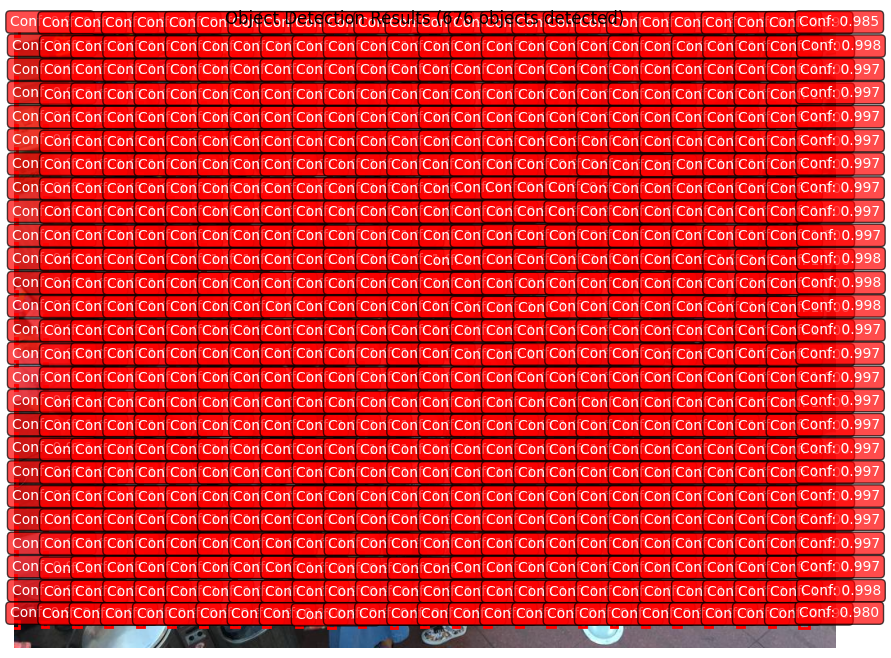


Testing on image: 270.jpg
Detected 676 objects
  Object 1: Confidence = 0.982, BBox = [-5, -3, 6, 4]
  Object 2: Confidence = 0.998, BBox = [35, -2, 42, 2]
  Object 3: Confidence = 0.997, BBox = [75, -2, 82, 2]
  Object 4: Confidence = 0.997, BBox = [114, -2, 122, 2]
  Object 5: Confidence = 0.997, BBox = [153, -2, 161, 2]
  Object 6: Confidence = 0.997, BBox = [193, -2, 200, 3]
  Object 7: Confidence = 0.997, BBox = [232, -2, 240, 3]
  Object 8: Confidence = 0.997, BBox = [271, -2, 279, 3]
  Object 9: Confidence = 0.997, BBox = [311, -2, 318, 2]
  Object 10: Confidence = 0.997, BBox = [350, -2, 358, 2]
  Object 11: Confidence = 0.997, BBox = [390, -2, 397, 2]
  Object 12: Confidence = 0.997, BBox = [429, -2, 437, 2]
  Object 13: Confidence = 0.997, BBox = [468, -2, 476, 2]
  Object 14: Confidence = 0.997, BBox = [508, -2, 515, 2]
  Object 15: Confidence = 0.997, BBox = [547, -2, 555, 2]
  Object 16: Confidence = 0.997, BBox = [587, -2, 594, 2]
  Object 17: Confidence = 0.997, BBox = 

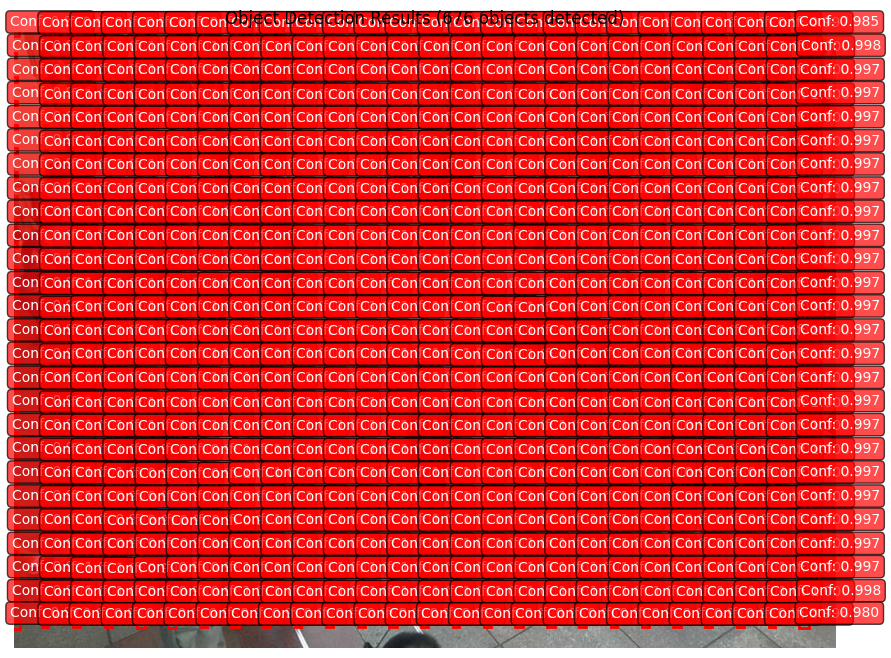


Testing on image: 7.jpg
Detected 676 objects
  Object 1: Confidence = 0.982, BBox = [-5, -3, 6, 4]
  Object 2: Confidence = 0.998, BBox = [35, -2, 42, 2]
  Object 3: Confidence = 0.997, BBox = [75, -2, 82, 2]
  Object 4: Confidence = 0.997, BBox = [114, -2, 122, 2]
  Object 5: Confidence = 0.997, BBox = [153, -2, 161, 2]
  Object 6: Confidence = 0.996, BBox = [193, -2, 201, 3]
  Object 7: Confidence = 0.996, BBox = [232, -2, 240, 3]
  Object 8: Confidence = 0.996, BBox = [271, -2, 279, 3]
  Object 9: Confidence = 0.997, BBox = [311, -2, 318, 2]
  Object 10: Confidence = 0.997, BBox = [350, -2, 358, 2]
  Object 11: Confidence = 0.997, BBox = [390, -2, 397, 2]
  Object 12: Confidence = 0.997, BBox = [429, -2, 437, 2]
  Object 13: Confidence = 0.997, BBox = [468, -2, 476, 2]
  Object 14: Confidence = 0.997, BBox = [508, -2, 515, 2]
  Object 15: Confidence = 0.997, BBox = [547, -2, 555, 2]
  Object 16: Confidence = 0.997, BBox = [587, -2, 594, 2]
  Object 17: Confidence = 0.997, BBox = [6

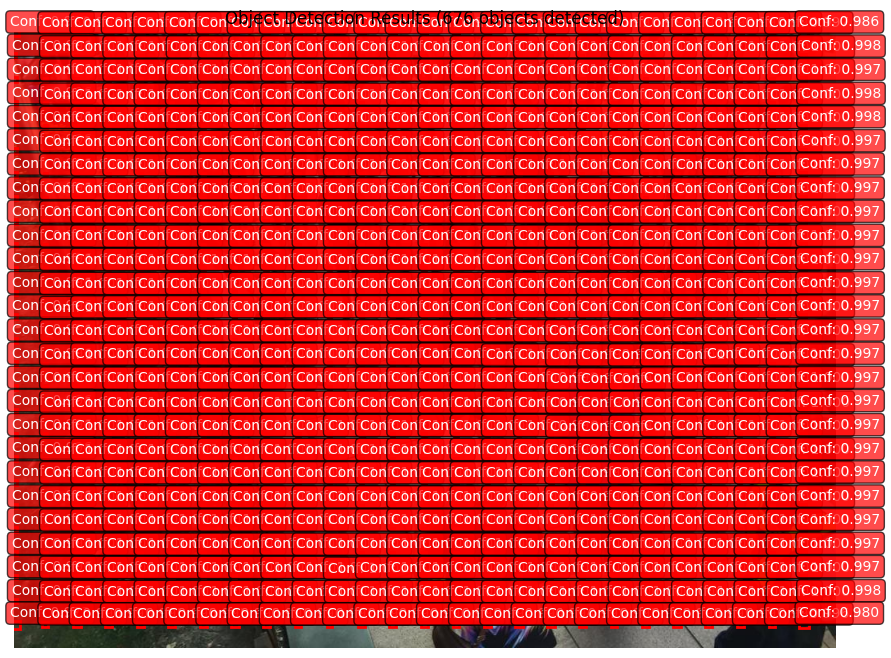

In [ ]:
# Test the model on sample images
model.eval()

# Get a sample test image
test_image_dir = '/content/dataset/test/images'
sample_images = [f for f in os.listdir(test_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

if sample_images:
    # Test on first few images
    for i, img_name in enumerate(sample_images[:3]):
        img_path = os.path.join(test_image_dir, img_name)
        print(f"\nTesting on image: {img_name}")

        # Predict objects
        detections = predict_objects(model, img_path, conf_threshold=0.3)
        print(f"Detected {len(detections)} objects")

        for j, det in enumerate(detections):
            print(f"  Object {j+1}: Confidence = {det['confidence']:.3f}, "
                  f"BBox = {det['bbox']}")

        # Visualize results
        visualize_predictions(img_path, detections)
else:
    print("No test images found!")

## Evaluation Metrics

In [ ]:
# Evaluation metrics
def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) of two bounding boxes"""
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate intersection
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    if x2_i <= x1_i or y2_i <= y1_i:
        return 0.0

    intersection = (x2_i - x1_i) * (y2_i - y1_i)
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0.0

def evaluate_model(model, test_loader, iou_threshold=0.5):
    """Evaluate model performance"""
    model.eval()
    total_tp = 0
    total_fp = 0
    total_fn = 0

    with torch.no_grad():
        for images, targets in test_loader:
            batch_size = images.size(0)

            for b in range(batch_size):
                # Get predictions for single image
                image = images[b:b+1].to(device)
                # Convert tensor back to numpy for prediction function
                img_np = (images[b].permute(1, 2, 0).numpy() * 255).astype(np.uint8)

                detections = predict_objects(model, img_np, conf_threshold=0.3)
                pred_boxes = [det['bbox'] for det in detections]

                # Get ground truth boxes
                target = targets[b]
                gt_boxes = []
                for obj in target:
                    if obj[0] >= 0:  # valid object
                        # Convert normalized coordinates to absolute
                        h, w = 416, 416  # assuming input size
                        x_center = obj[1] * w
                        y_center = obj[2] * h
                        width = obj[3] * w
                        height = obj[4] * h

                        x1 = int(x_center - width/2)
                        y1 = int(y_center - height/2)
                        x2 = int(x_center + width/2)
                        y2 = int(y_center + height/2)
                        gt_boxes.append([x1, y1, x2, y2])

                # Calculate TP, FP, FN
                matched_gt = set()
                for pred_box in pred_boxes:
                    best_iou = 0
                    best_gt_idx = -1

                    for gt_idx, gt_box in enumerate(gt_boxes):
                        if gt_idx not in matched_gt:
                            iou = calculate_iou(pred_box, gt_box)
                            if iou > best_iou:
                                best_iou = iou
                                best_gt_idx = gt_idx

                    if best_iou >= iou_threshold:
                        total_tp += 1
                        matched_gt.add(best_gt_idx)
                    else:
                        total_fp += 1

                total_fn += len(gt_boxes) - len(matched_gt)

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Evaluation Results:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1_score:.3f}")
    print(f"True Positives: {total_tp}")
    print(f"False Positives: {total_fp}")
    print(f"False Negatives: {total_fn}")

    return precision, recall, f1_score

# Evaluate the model
precision, recall, f1_score = evaluate_model(model, test_loader)

Evaluation Results:
Precision: 0.000
Recall: 0.000
F1-Score: 0.000
True Positives: 0
False Positives: 338000
False Negatives: 500


## Save Training Model

In [ ]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'model_config': {
        'num_classes': 1,
        'img_size': 416
    }
}, 'simple_object_detector.pth')

print("Model saved as 'simple_object_detector.pth'")

# Function to load model for inference
def load_model(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    model = SimpleObjectDetector(num_classes=1).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

print("\nObject Detection Pipeline Complete!")
print("You can now use the trained model to detect objects in new images.")

Model saved as 'simple_object_detector.pth'

Object Detection Pipeline Complete!
You can now use the trained model to detect objects in new images.
